In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

In [3]:
import saga_optimizer

In [4]:
x0 = torch.full((3,), fill_value=0, dtype=torch.double)

d = 10

np.random.seed(0)
A = torch.randn(d, len(x0), dtype=torch.double)
b = torch.randn(d, dtype=torch.double)
K_max = 0
for i in range(0, d):
    K = torch.sqrt(((A[i] @ A[i].t()) ** 2).sum())
    K_max = max(K, K_max)
L = 1 / (10 * K)

print(L)

x_opt = torch.inverse(A.t() @ A) @ A.t() @ b

functions = [
    lambda x, i=i: (A[i] @ x - b[i])**2
    for i in range(d)
]
calc_value = lambda x: sum(f(x) for f in functions)
# minimum = calc_value(torch.full((2,), 0.5)).item()
minimum = calc_value(x_opt)

tensor(0.0211, dtype=torch.float64)


In [5]:
max_grad_calls = 2000

In [6]:
x = x0.clone().detach_().requires_grad_(True)

opt = saga_optimizer.SAGAOptimizer(x, functions, lr=L)

grad_calls_saga = [0]
errors_saga = [calc_value(x).item() - minimum]

grad_calls = 0
while grad_calls < max_grad_calls:
    opt.step()
    grad_calls += 1
    
    errors_saga.append(calc_value(x).item() - minimum)
    grad_calls_saga.append(grad_calls)

In [7]:
x = x0.clone().detach_().requires_grad_(True)

opt = torch.optim.SGD([x], lr=L, momentum=0.9, nesterov=True)

grad_calls_nesterov = [0]
errors_nesterov = [calc_value(x).item() - minimum]

grad_calls = 0
while grad_calls < max_grad_calls:
    opt.zero_grad()
    calc_value(x).backward()
    opt.step()
    grad_calls += len(functions)
    
    errors_nesterov.append(calc_value(x).item() - minimum)
    grad_calls_nesterov.append(grad_calls)

In [8]:
x = x0.clone().detach_().requires_grad_(True)

opt = torch.optim.LBFGS([x], lr=L)

errors_lbfgs = [calc_value(x).item() - minimum]
grad_calls_lbfgs = [0]

grad_calls = 0
def closure():
    global grad_calls
    opt.zero_grad()
    val = calc_value(x)
    val.backward()
    grad_calls += len(functions)
    return val

while grad_calls < max_grad_calls:
    opt.step(closure)
    errors_lbfgs.append(calc_value(x).item() - minimum)
    grad_calls_lbfgs.append(grad_calls)

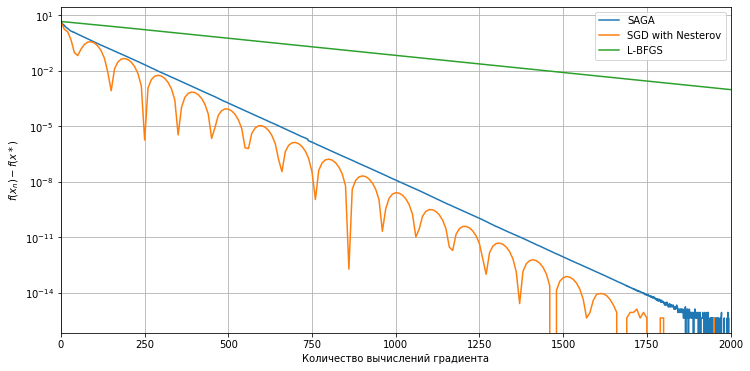

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(grad_calls_saga, errors_saga, label="SAGA")
plt.plot(grad_calls_nesterov, errors_nesterov, label="SGD with Nesterov")
plt.plot(grad_calls_lbfgs, errors_lbfgs, label="L-BFGS")
plt.legend()
plt.xlim(0, max_grad_calls)
plt.yscale("log")
plt.xlabel("Количество вычислений градиента")
plt.ylabel(R"$f(x_n) - f(x*)$")
plt.grid()
plt.show()